# 1. Autocorrelation

'babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as a time series.

1. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John`.

2. Which name do you expect to be the most popular in 2022? Use an ARIMA model and backtesting to pick 3 interesting candidates. Support your findings with a plot

In [1]:
import pandas as pd
import os, zipfile
from zipfile import ZipFile
import numpy as np
import datetime

import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# https://github.com/PhantomInsights/baby-names-analysis
# https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

In [2]:
df = pd.DataFrame()
i = 0
with ZipFile('data/babies.zip') as myzip:
    list_files = myzip.namelist()
    for f in list_files:
        if f.endswith('txt')==True:    
            with myzip.open(f) as myfile:
                df_temp = pd.read_csv(myfile,header=None,encoding='UTF-8',names=['name','sex','count'])
                df_temp['file_name'] = f 
                df = pd.concat([df,df_temp],ignore_index=True)



In [3]:
df['year'] = df.file_name.str.slice(start=3,stop=7)

In [4]:
df = df[['year','name','count']]

In [5]:
df.to_csv('data/babies.csv', index=False)                

In [6]:
df.year = pd.to_datetime(df.year)#, format='%Y')

In [33]:
df = df.set_index('year').sort_index()

In [7]:
df_olivia = df.loc[df.name=='Olivia']
df_newton = df.loc[df.name=='Newton']
df_john = df.loc[df.name=='John']

In [8]:
df_john = df_john[['name','year','count']]
df_newton = df_newton[['name','year','count']]
df_olivia = df_olivia[['name','year','count']]

In [51]:
df_john_gb = df_john.groupby(["year"]).sum().reset_index()
df_newton_gb = df_newton.groupby(["year"]).sum().reset_index()
df_olivia_gb = df_olivia.groupby(["year"]).sum().reset_index()

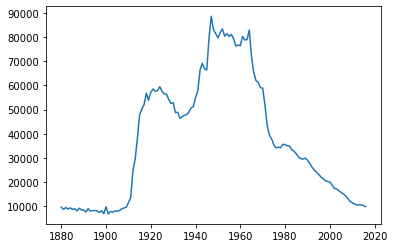

In [52]:
df_john_gb = df_john_gb.set_index('year')
plt.plot(df_john_gb)

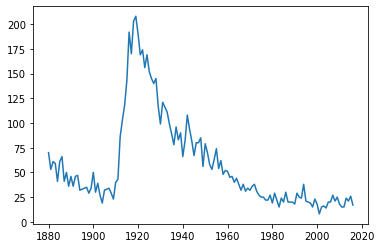

In [53]:
df_newton_gb =  df_newton_gb.set_index('year')
plt.plot(df_newton_gb)

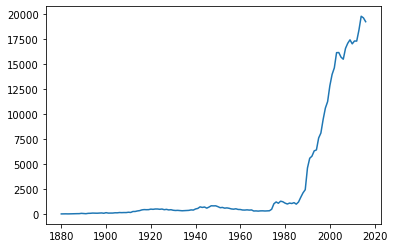

In [54]:
df_olivia_gb = df_olivia_gb.set_index('year')
plt.plot(df_olivia_gb)

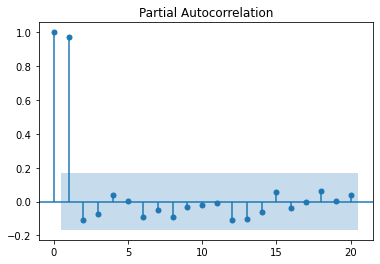

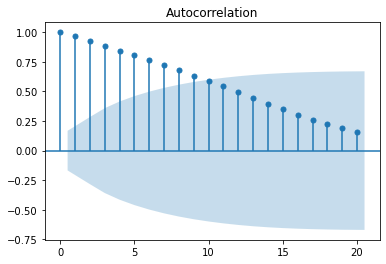

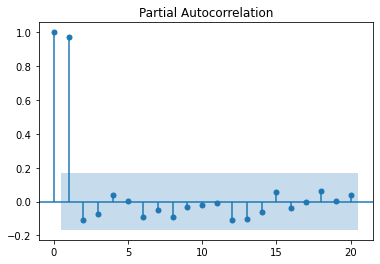

In [55]:
plot_acf(df_olivia_gb, lags=20)
plot_pacf(df_olivia_gb, lags=20)

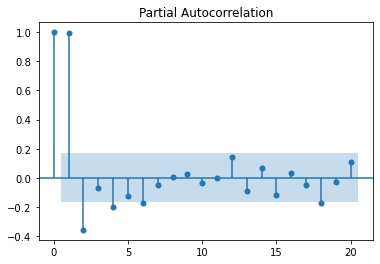

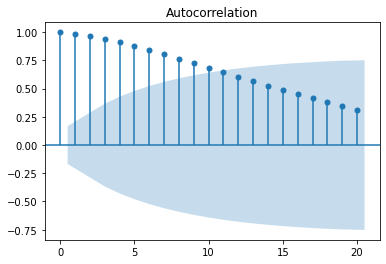

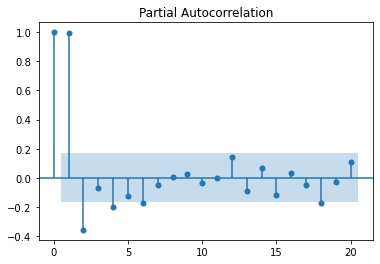

In [56]:
plot_acf(df_john_gb, lags=20)
plot_pacf(df_john_gb, lags=20)

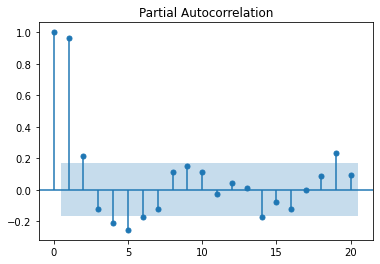

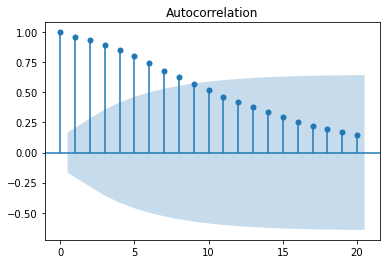

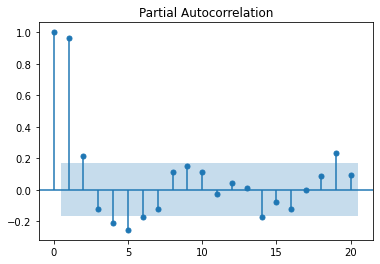

In [57]:
plot_acf(df_newton_gb, lags=20)
plot_pacf(df_newton_gb, lags=20)

In [61]:
df_train

,count
year,
1880-01-01,70
1881-01-01,53
1882-01-01,61
1883-01-01,59
1884-01-01,41
...,...
1988-01-01,20
1989-01-01,20
1990-01-01,18


C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


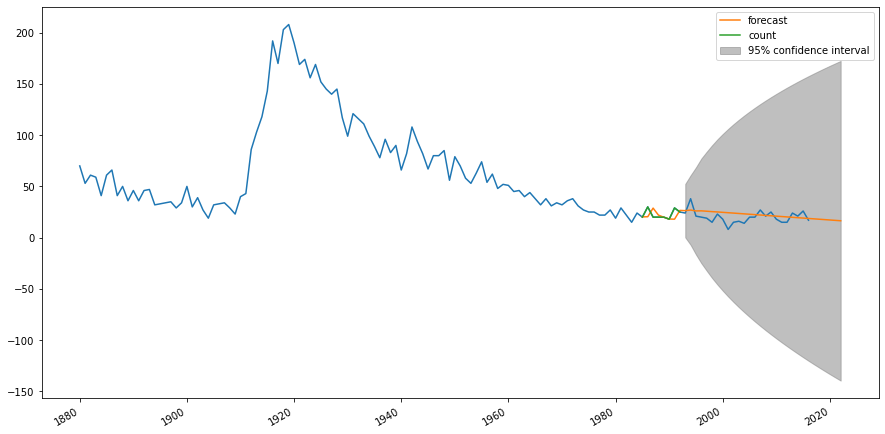

In [98]:
#2 
from statsmodels.tsa.arima_model import ARIMA
df_train = df_newton_gb.iloc[:-24]
df_test = df_newton_gb.iloc[-24:]


model = ARIMA(df_train, order=(3,1,0))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_newton_gb)
res.plot_predict('1985', '2022', ax=ax);

In [117]:
len(df_john_gb)

137

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


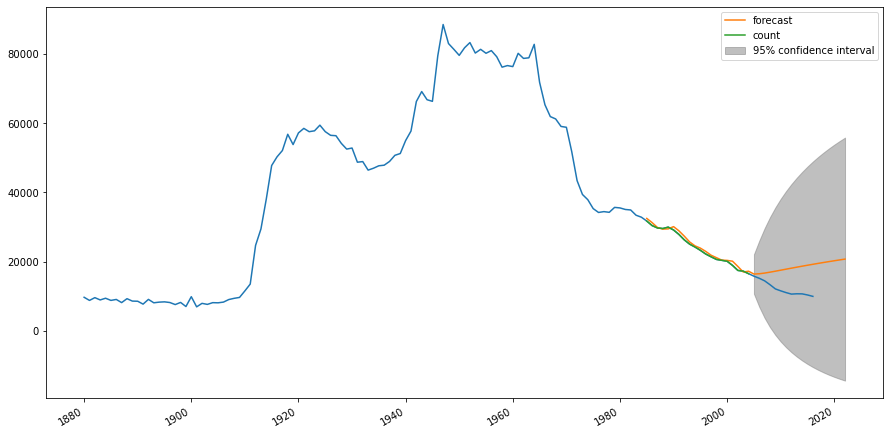

In [136]:
df_train = df_john_gb.iloc[:-12]
df_test = df_john_gb.iloc[-12:]


model = ARIMA(df_train, order=(3,0,0))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_john_gb)
res.plot_predict('1985', '2022', ax=ax);

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1541: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep ** 2))


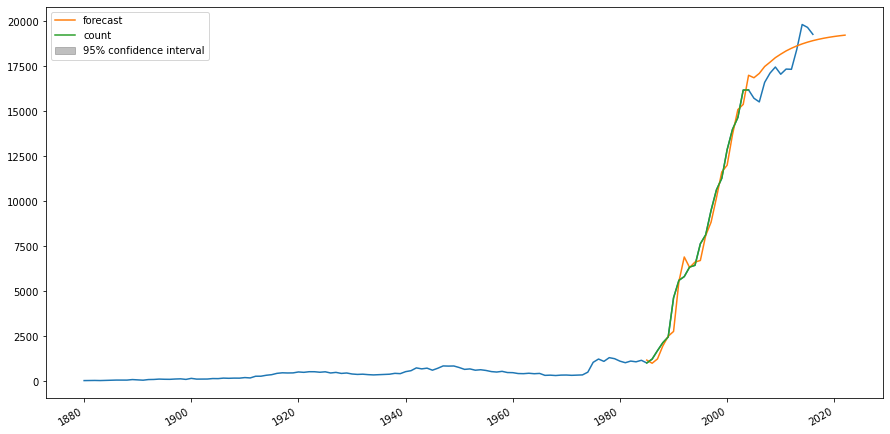

In [135]:
df_train = df_olivia_gb.iloc[:-12]
df_test = df_olivia_gb.iloc[-12:]


model = ARIMA(df_train, order=(3,0,0))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_olivia_gb)
res.plot_predict('1985', '2022', ax=ax);

# 2. Counterfactual prediction testing

The [FRED](https://fred.stlouisfed.org) database has economic data useful for this question.

A common method to test the effect of a one-off event is to fit an ARIMA model up to the event, and compare the forecast to the actual data of what happened, then measure the gap between the forecast and the event data.

1. Use GDP and unemployment data with the Counterfactual prediction testing methodology to get an estimate of the magnitude of COVID (around March 2020 as a cutoff date) on these two statistics. Use an ARIMA model which fits best to the pre-COVID time series and compare the output of both. Provide a visualization.

2. Is GDP a unit root process or trend stationary? Use the 2008 and 2020 GDP shocks and statistical tests we've seen in class to provide an argument (it's possible event one says one thing and the other event says the opposite).

In [ ]:
https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html


In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set()

In [21]:
# Use dickey fuller test to determine stationary

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [18]:
gdp = pd.read_csv('data/gdp.csv')
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp.set_index('DATE')
gdp

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114


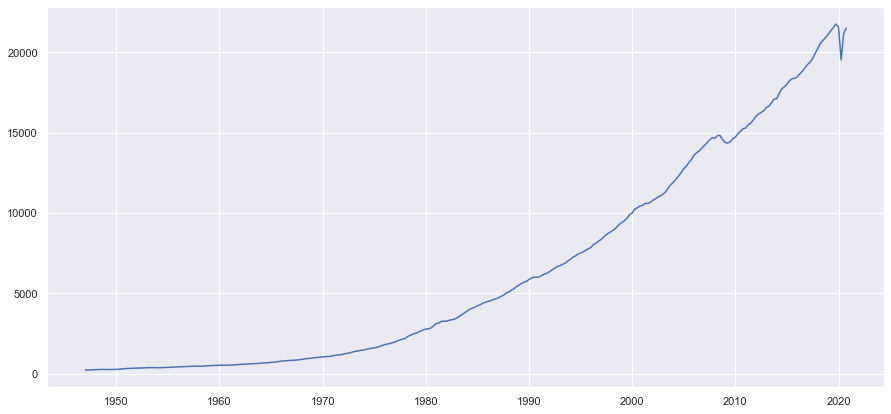

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(gdp)

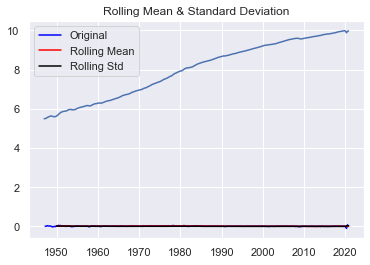

Results of Dickey-Fuller Test:


Test Statistic                -8.374317e+00
p-value                        2.611029e-13
#Lags Used                     1.000000e+00
Number of Observations Used    2.930000e+02
Critical Value (1%)           -3.452867e+00
Critical Value (5%)           -2.871455e+00
Critical Value (10%)          -2.572053e+00
dtype: float64

In [22]:
ts_log = np.log(gdp)
plt.plot(ts_log)
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_acf((gdp - gdp.shift())[1:], lags=20)

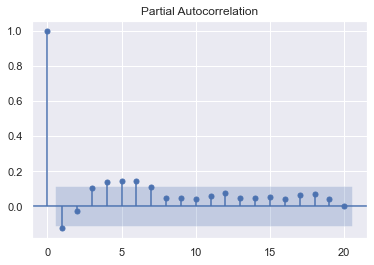

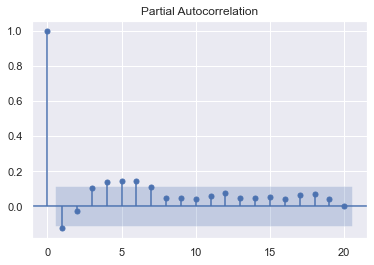

In [25]:
plot_pacf((gdp - gdp.shift())[1:], lags=20)

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


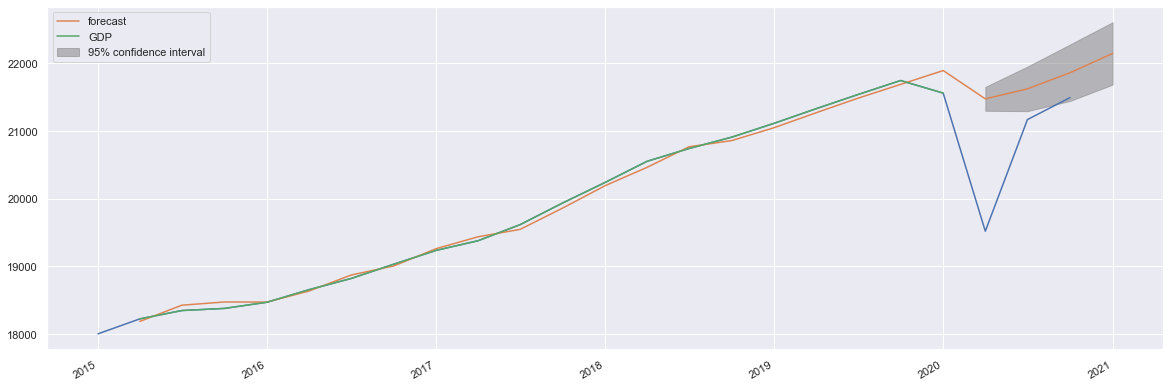

In [26]:
from statsmodels.tsa.arima_model import ARIMA

df_train = gdp.loc['2015-01-01':'2020-01-01']
df_test = gdp.loc['2020-04-01':'2020-10-01']

model = ARIMA(df_train, order=(3, 1, 2))  
res = model.fit(disp=-1)

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(gdp.loc['2015-01-01':'2020-10-01'])
res.plot_predict('2015', '2021', ax=ax);

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


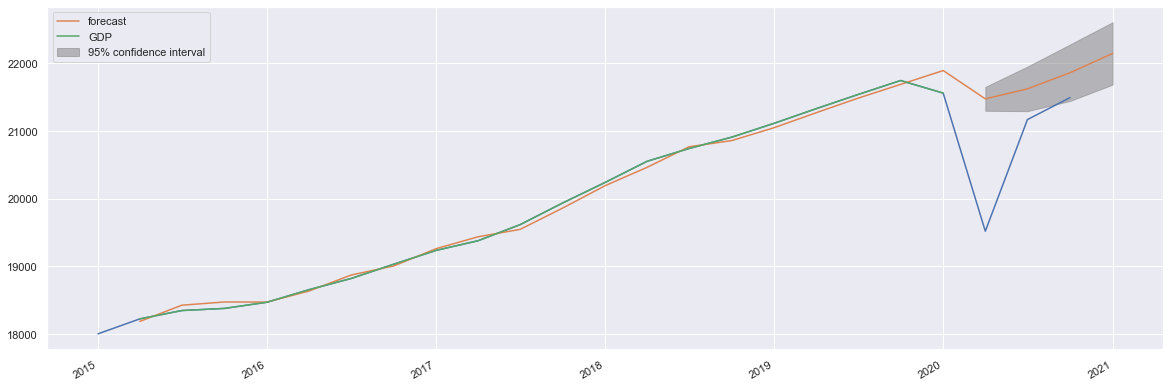

In [27]:
from statsmodels.tsa.arima_model import ARIMA

df_train = gdp.loc['2015-01-01':'2020-01-01']
df_test = gdp.loc['2020-04-01':'2020-10-01']

model = ARIMA(df_train, order=(3, 1, 2))  
res = model.fit(disp=-1)

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(gdp.loc['2015-01-01':'2020-10-01'])
res.plot_predict('2015', '2021', ax=ax);

In [28]:
unrate = pd.read_csv('data/unrate.csv')
unrate['DATE'] = pd.to_datetime(unrate['DATE'])
unrate = unrate.set_index('DATE')
unrate.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


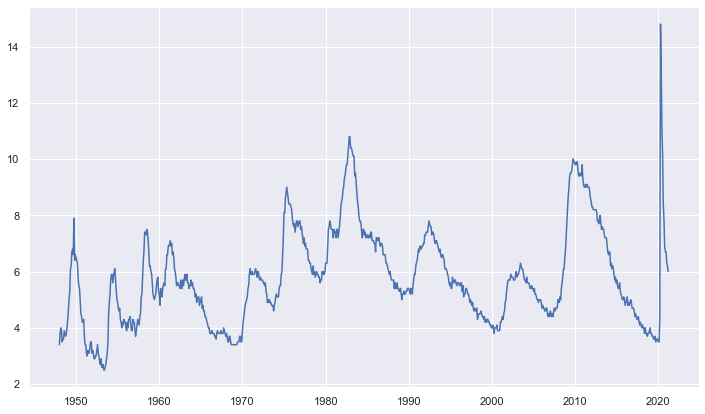

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(unrate)

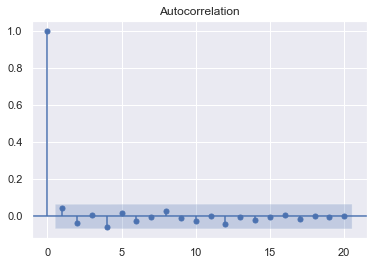

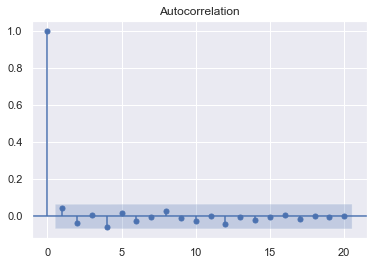

In [30]:
plot_acf((unrate - unrate.shift())[1:], lags=20)

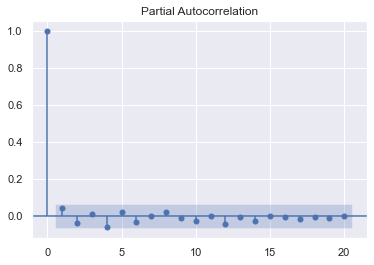

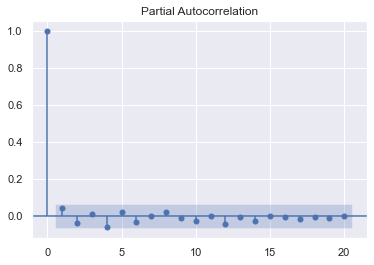

In [31]:
plot_pacf((unrate - unrate.shift())[1:], lags=20)

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


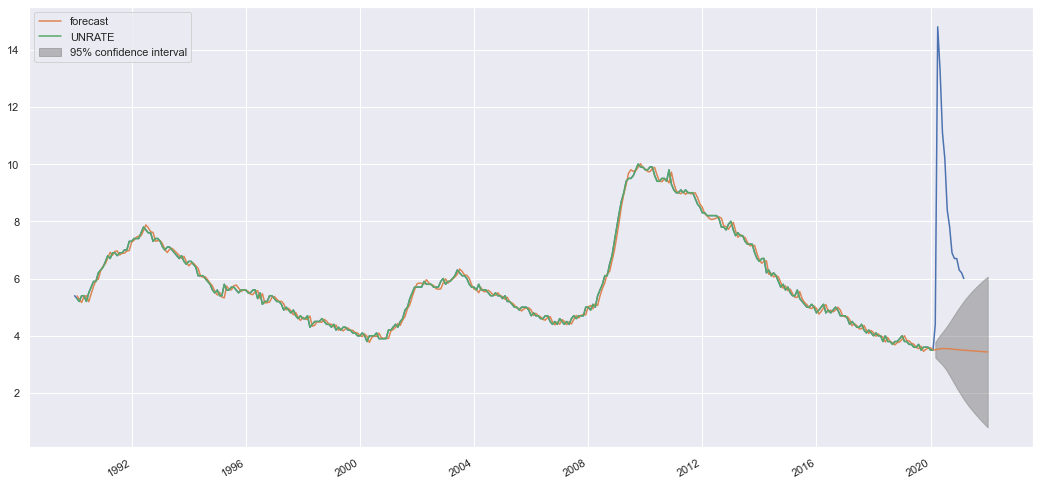

In [32]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

df_train = unrate.loc['1990-01-01':'2020-02-01']
df_test = unrate.loc['2020-03-01':'2021-03-01']

model = ARIMA(df_train, order=(4, 1, 2))  
res = model.fit(disp=-1)

fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(unrate.loc['1990-01-01':'2021-03-01'])
res.plot_predict('1990', '2022', ax=ax);

        
    GDP is not stationary given that the Test Statistic is greater than the Critical Value, we can adopt the null hypothesis and say that the series is non-stationary.
       
       1. there is is a visible positive trend over time
    
    GDP seems to follow a unit root process, where the shock of an event is absorbed into the data, however the series does not make a return to original mean.
    This can be seen of the 2008 shock that permanently downshifted the growth for the years to come.
    While the shock was a lot sharper in 2020 due to pandemic, the series does seem to attempt at recovery, although it is likely to suffer the same consquences and fail to return to the original mean 
       
       

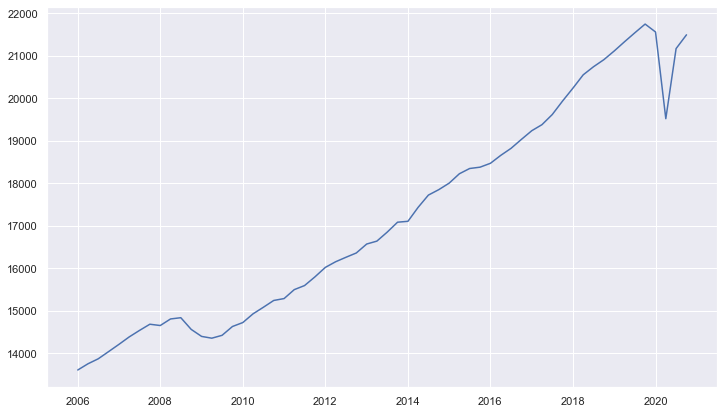

In [33]:
plt.figure(figsize=(12, 7))
gdp_slice = gdp[-60:]
plt.plot(gdp_slice)

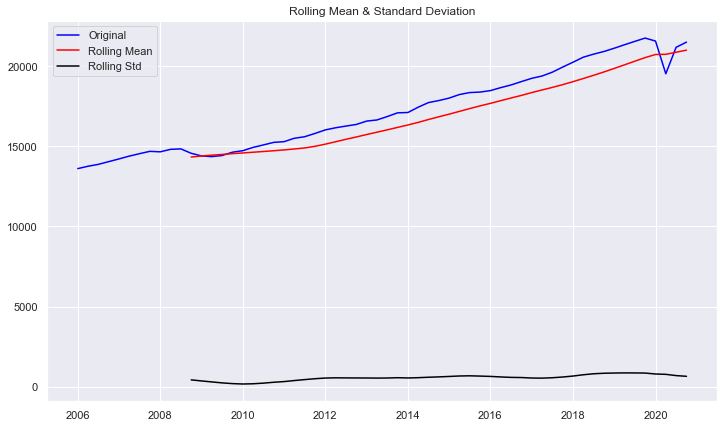

Results of Dickey-Fuller Test:


Test Statistic                  0.027955
p-value                         0.960784
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64

In [34]:
plt.figure(figsize=(12, 7))
test_stationarity(gdp_slice)

In [10]:
GDP = pd.read_csv('data/GDP.csv')

In [11]:
GDP.DATE = pd.to_datetime(GDP.DATE)

In [13]:
GDP = GDP.set_index('DATE')

In [8]:
import seaborn as sns
sns.set()

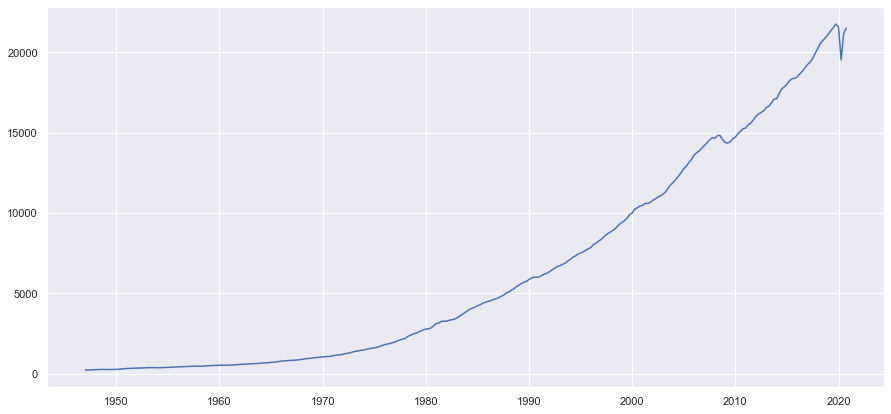

In [14]:
plt.figure(figsize=(15,7))

plt.plot(GDP)

C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\mr_na\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1541: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep ** 2))


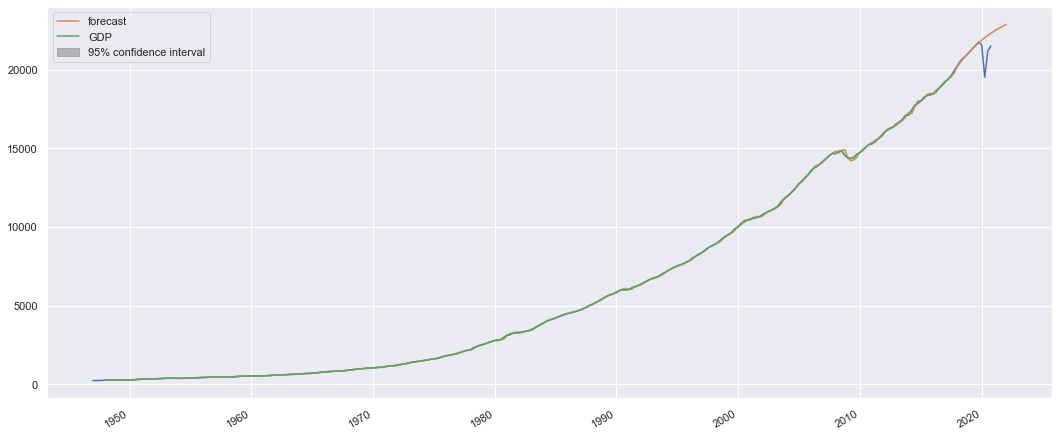

In [16]:
df_train = GDP.iloc[:-12]
df_test = GDP.iloc[-12:]


model = ARIMA(df_train, order=(3,0,0))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(GDP)
res.plot_predict('1948', '2022', ax=ax);